# Tally a Flux Spectrum

In this example, we will demonstrate how to get the neutron flux as a function of energy (commonly called a flux spectrum). We will use a pre-built module from the `openmc.examples` package.

In [1]:
%matplotlib inline
import openmc.examples
import numpy as np
import matplotlib.pyplot as plt

First, we'll generate a pin-cell model:

In [2]:
model = openmc.examples.pwr_pin_cell()

By default, the model has no tallies.

In [3]:
model.tallies

[]

To get the flux spectrum, we just need to create a flux tally with an energy filter. We can take advantage of numpy to get an energy filter specifying equal-lethargy bins. Let's create an energy filter with 500 energy bins.

In [4]:
# Create equal-lethargy energies to put in filter
energies = np.logspace(np.log10(1e-5), np.log10(20.0e6), 501)
e_filter = openmc.EnergyFilter(energies)

# Create tally with energy filter
tally = openmc.Tally()
tally.filters = [e_filter]
tally.scores = ['flux']

# Set model tallies
model.tallies = [tally]

OpenMC also has a set of predefined energy group structures that you can take advantage of. Let's see what's available:

In [5]:
openmc.mgxs.GROUP_STRUCTURES.keys()

dict_keys(['CASMO-2', 'CASMO-4', 'CASMO-8', 'CASMO-16', 'CASMO-25', 'CASMO-40', 'VITAMIN-J-42', 'SCALE-44', 'CASMO-70', 'XMAS-172', 'VITAMIN-J-175', 'TRIPOLI-315', 'SHEM-361', 'CCFE-709', 'UKAEA-1102'])

Let's also add a flux spectrum tally using the SHEM-361 group structure.

In [6]:
# Create energy filter using SHEM-361 group structure
energies_shem = openmc.mgxs.GROUP_STRUCTURES['SHEM-361']
shem_filter = openmc.EnergyFilter(openmc.mgxs.GROUP_STRUCTURES['SHEM-361'])

tally_shem = openmc.Tally()
tally_shem.filters = [shem_filter]
tally_shem.scores = ['flux']

model.tallies.append(tally_shem)

Now let's run the model (making sure to set the number of particles/batches slightly higher than the default values).

In [7]:
model.settings.particles = 10000
model.settings.batches = 50
sp_path = model.run(output=False)

Great, the simulation is done. To get our results, we need to load data from the statepoint file. We can get the corresponding tallies from the statepoint file and get the mean values for each energy bin by using the `mean` attribute on the tallies.

In [8]:
with openmc.StatePoint(sp_path) as sp:
    t = sp.tallies[tally.id]
    flux500_mean = t.mean.ravel()
    flux500_unc = t.std_dev.ravel()
    
    t_shem = sp.tallies[tally_shem.id]
    flux_shem_mean = t_shem.mean.ravel()
    flux_shem_unc = t_shem.std_dev.ravel()

Now we can use matplotlib to plot the flux versus the energy. Note that we divide by the energy bin width so that integrating the curve makes sense. This appropriately highlights the fact that most of the spectrum is thermal.

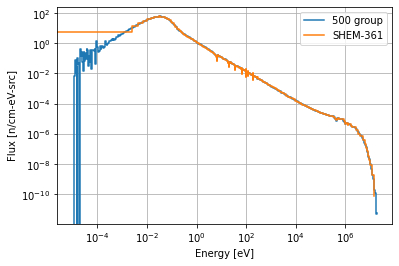

In [9]:
fig, ax = plt.subplots()
ax.step(energies[:-1], flux500_mean/np.diff(energies), where='post', label='500 group')
ax.step(energies_shem[:-1], flux_shem_mean/np.diff(energies_shem), where='post', label='SHEM-361')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Energy [eV]')
ax.set_ylabel('Flux [n/cm-eV-src]')
ax.grid()
ax.legend()

If we don't divide by the energy bin width, we obtain a plot where the different curves aren't directly comparable.

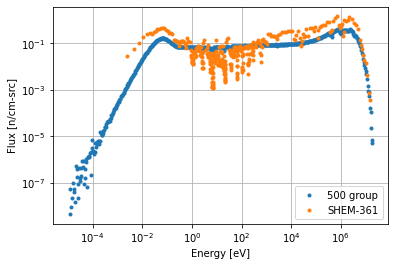

In [10]:
fig, ax = plt.subplots()
ax.loglog(energies[:-1], flux500_mean, '.', color='C0', label='500 group')
ax.loglog(energies_shem[:-1], flux_shem_mean, '.', color='C1', label='SHEM-361')
ax.set_xlabel('Energy [eV]')
ax.set_ylabel('Flux [n/cm-src]')
ax.grid()
ax.legend()